In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [9]:
# Funciones auxiliares generales
def filtrar_outliers(df, columna, p_inf=0.01, p_sup=0.99):
    """Filtra valores extremos de una columna numérica usando percentiles."""
    lim_inf = df[columna].quantile(p_inf)
    lim_sup = df[columna].quantile(p_sup)
    return df[df[columna].between(lim_inf, lim_sup)]

# Cargar y preparar los datos
def cargar_datos(ruta):
    df = pd.read_csv(ruta)
    df["cholesterol"] = (df["cholesterol"] > 1).astype(int)
    df["gluc"] = (df["gluc"] > 1).astype(int)
    df["age_years"] = (df["age"] / 365).astype(int)
    return df

def agregar_bmi(df):
    """Calcula el IMC y agrega las columnas 'BMI' e 'overweight' al DataFrame."""
    bmi = df["weight"] / ((df["height"] / 100) ** 2)
    df["BMI"] = bmi
    df["overweight"] = (bmi > 25).astype(int)
    return df

In [10]:
ruta = "C:/Users/trezz/Desktop/proyectosDeDesarrolloWeb/MedicalExamination/data/medical_examination.csv"
df = cargar_datos(ruta)
df = agregar_bmi(df)

# Regresion Lineal

In [11]:
def scatterplot_regresion(df, x="age_years", y="ap_hi", p_inf=0.01, p_sup=0.99,
                          max_muestras=None, titulo=None):
    """
    Visualización de regresión lineal simple con filtrado de outliers y control de muestras.
    """
    # Filtrar outliers
    df_filtrado = filtrar_outliers(df, x, p_inf, p_sup)
    df_filtrado = filtrar_outliers(df_filtrado, y, p_inf, p_sup)

    # Limitar muestras
    if max_muestras is not None and len(df_filtrado) > max_muestras:
        df_filtrado = df_filtrado.sample(max_muestras, random_state=42)

    # Modelo
    X = df_filtrado[[x]]
    Y = df_filtrado[y]
    modelo = LinearRegression()
    modelo.fit(X, Y)


    y_pred = modelo.predict(X)
    print(f"Coeficiente: {modelo.coef_[0]:.2f}")
    print(f"Intercepto: {modelo.intercept_:.2f}")
    print(f"R²: {r2_score(Y, y_pred):.3f}")
    print(f"MSE: {mean_squared_error(Y, y_pred):.2f}")

    # Visualización
    plt.scatter(X, Y, alpha=0.4)
    plt.plot(X, modelo.predict(X), color='red')
    plt.title(titulo or f"{y} vs {x} (Regresión lineal)")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()
    plt.close()


Coeficiente: 0.61
Intercepto: 93.01
R²: 0.069
MSE: 225.98


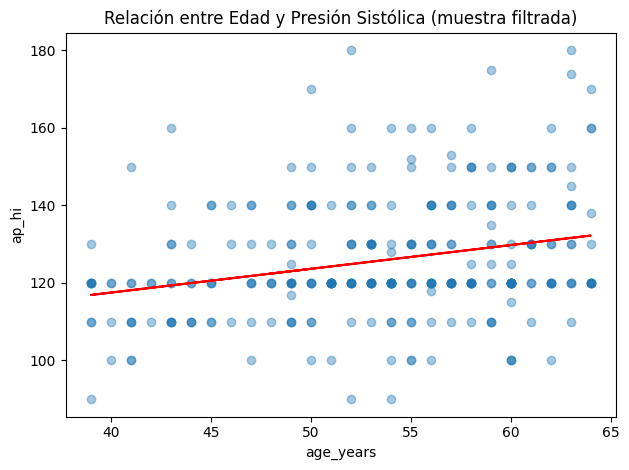

In [12]:
"""
Si R² es bajo (por ejemplo, < 0.1), significa que la edad explica muy poco de la variabilidad en presión sistólica.
"""
scatterplot_regresion(df, x="age_years", y="ap_hi", max_muestras=300,
                      titulo="Relación entre Edad y Presión Sistólica (muestra filtrada)")


# Regresion Logistica

In [13]:
def modelo_logistico(df, features, objetivo="cardio", p_inf=0.01, p_sup=0.99,
                     max_muestras=None, test_size=0.2, random_state=42, titulo=None):
    """
    Entrenamiento y evaluación de regresión logística binaria con filtrado de outliers,
    control de muestras, métricas y visualización.
    """
    # Filtrar outliers en cada variable numérica usada
    df_filtrado = df.copy()
    for var in features + [objetivo]:
        if df[var].dtype in ["float64", "int64"]:
            df_filtrado = filtrar_outliers(df_filtrado, var, p_inf, p_sup)

    # Limitar muestras
    if max_muestras is not None and len(df_filtrado) > max_muestras:
        df_filtrado = df_filtrado.sample(max_muestras, random_state=random_state)

    # Separar variables
    X = df_filtrado[features]
    y = df_filtrado[objetivo]

    # División entrenamiento/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Modelo
    modelo = LogisticRegression(max_iter=1000)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:,1]

    # Métricas
    print("\nEvaluación del modelo:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Visualización: Matriz de confusión
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(titulo or "Matriz de confusión - Regresión Logística")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()
    plt.close()

    # Visualización: Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC - Regresión Logística")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    plt.close()



Evaluación del modelo:
Accuracy: 0.734

Matriz de confusión:
 [[387 106]
 [160 347]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.71      0.78      0.74       493
           1       0.77      0.68      0.72       507

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



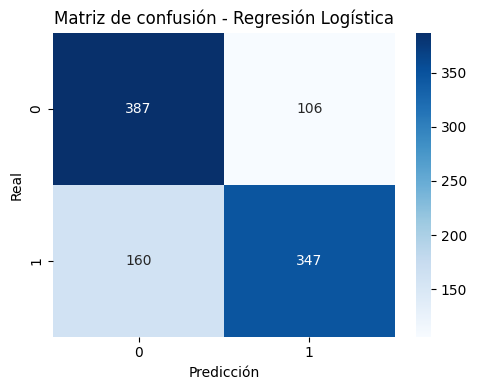

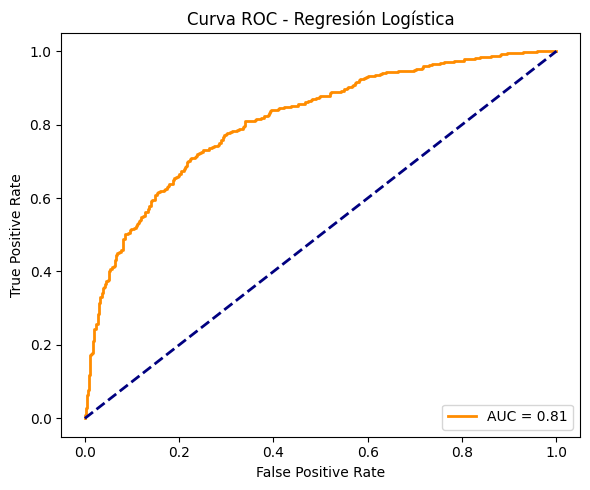

In [14]:
features = ["age_years", "BMI", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active"]
modelo_logistico(df, features, max_muestras=5000)


387 pacientes sanos fueron correctamente clasificados como sanos → True Negatives (TN)

347 pacientes enfermos fueron correctamente clasificados como enfermos → True Positives (TP)

106 sanos fueron clasificados como enfermos → False Positives (FP)

160 enfermos fueron clasificados como sanos → False Negatives (FN)

El modelo detecta bien a los sanos (387 TN vs 106 FP), pero se equivoca bastante con los enfermos (160 FN).